In [2]:
import pandas as pd
from pandas import DataFrame as dframe
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy.random import choice
from numpy import array as arr

import jax as j
cpu = j.devices("cpu")[0]
from jax import random, vmap
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro import sample, plate, param, deterministic
from numpyro.optim import Adam, Minimize
from numpyro.infer.autoguide import AutoLaplaceApproximation
from numpyro.diagnostics import hpdi, print_summary
from numpyro.infer import SVI, Trace_ELBO, init_to_value, Predictive

import utils
from utils import attach
from utils.data import data, scale
from utils.analysis import * # precis, cov2cor
from utils.stats import * # r::stats functions (rnorm, dnorm, ...)
from utils.plots import init_dag, scatter, shade, dens
utils.init() # init plotting styles and hush warnings
seed = random.PRNGKey(42)

In [2]:
d = data("Howell1")
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


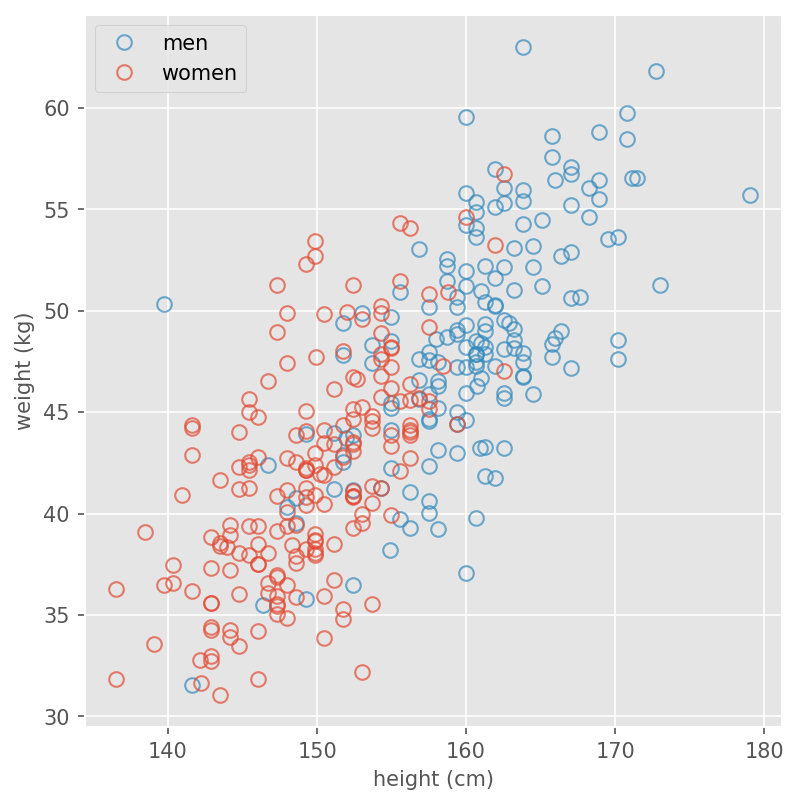

In [3]:
d2 = d[d.age >= 18]
d2m = d2[d.male == 1]
d2f = d2[d.male == 0]

_, ax = plt.subplots(figsize=(6, 5))
ax.set(xlabel="height (cm)", ylabel="weight (kg)")
scatter(d2m.height, d2m.weight, c="C1", label="men")
scatter(d2f.height, d2f.weight, c="C0", label="women")
ax.legend();

### Think scientifically first

How are height, weight, and sex __causally & statistically__ related?

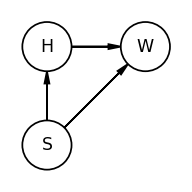

In [4]:
dag_hws = init_dag()
dag_hws.add_node("S", "S", 0, 0)
dag_hws.add_node("H", "H", 0, 1)
dag_hws.add_node("W", "W", 1, 1)
dag_hws.add_edge("S", "H")
dag_hws.add_edge("S", "W")
dag_hws.add_edge("H", "W")
dag_hws.show()

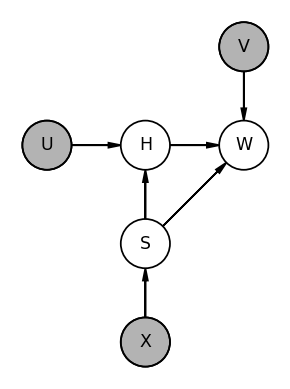

In [5]:
dag_hws1 = init_dag()
dag_hws1.add_node("S", "S", 0, 0)
dag_hws1.add_node("H", "H", 0, 1)
dag_hws1.add_node("W", "W", 1, 1)
dag_hws1.add_node("U", "U", -1, 1, alternate=True)
dag_hws1.add_node("X", "X", 0, -1, alternate=True)
dag_hws1.add_node("V", "V", 1, 2, alternate=True)
dag_hws1.add_edge("S", "H")
dag_hws1.add_edge("S", "W")
dag_hws1.add_edge("H", "W")
dag_hws1.add_edge("U", "H")
dag_hws1.add_edge("V", "W")
dag_hws1.add_edge("X", "S")
dag_hws1.show()

Unobserved causes, if not shared, can be ignored.

For some animals like turtles and lizards:

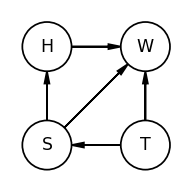

In [6]:
dag_hws_ = init_dag()
dag_hws_.add_node("S", "S", 0, 0)
dag_hws_.add_node("H", "H", 0, 1)
dag_hws_.add_node("W", "W", 1, 1)
dag_hws_.add_node("T", "T", 1, 0)
dag_hws_.add_edge("S", "H")
dag_hws_.add_edge("S", "W")
dag_hws_.add_edge("H", "W")
dag_hws_.add_edge("T", "S")
dag_hws_.add_edge("T", "W")
dag_hws_.show()

Temperature affects the sex ratio of newborns. For turtles, more female eggs hatch if higher temperature. Lizards are the opposite. Here temperature is a common cause of S and W, so cannot be ignored.

### Simulation

In [7]:
def sim_HW(S, b, a):
    N = len(S)
    H = np.where(S == 0, 150, 160) + rnorm(N, 0, 5)
    W = a[S] + b[S]*H + rnorm(N, 0, 5)
    return dframe(dict(S=S, H=H, W=W))


S = rbern(100)
dat = sim_HW(S, b=arr([.5, .6]), a=arr([0, 0]))
dat.head()

,S,H,W
0,0,150.770427,74.801275
1,1,163.276700,107.709517
2,0,148.657497,72.506857
3,1,160.482064,100.768189
4,1,159.428190,96.362405


### Using index variables

$$W_i \sim \text{Normal}(\mu_i, \sigma)$$
$$\mu_i = \alpha_{S[i]}$$
$$\alpha_j \sim \text{Normal}(60, 10)$$
$$\sigma \sim \text{Uniform}(0, 60)$$

### Simulate the total causal effect of S on W

In [8]:
# female sample
S = np.repeat(0, 100)
simF = sim_HW(S, b=arr([.5, .6]), a=arr([0, 0]))

# male sample
S = np.repeat(1, 100)
simM = sim_HW(S, b=arr([.5, .6]), a=arr([0, 0]))

# total effect of S on W
(simM.W - simF.W).mean().round(5)

22.1101

In [9]:
S = rbern(100)
dat = sim_HW(S, b=arr([.5, .6]), a=arr([0, 0]))

In [3]:
def f_SW(S, W=None):
    a = sample("a", dist.Normal(60, 10).expand([len(set(S))]))
    mu = a[S]
    sigma = sample("sigma", dist.Uniform(0, 10))
    sample("W", dist.Normal(mu, sigma), obs=W)
    
    
m_SW = AutoLaplaceApproximation(f_SW)

In [11]:
dat = dict(S=dat.S.values, W=dat.W.values)
p_SW = (SVI(f_SW, m_SW, Adam(.1), Trace_ELBO())
           .run(seed, 15000, **dat).params)
post_SW = m_SW.sample_posterior(seed, p_SW, (1, 1000))
post_SW["a_diff"] = post_SW["a"][..., 1] - post_SW["a"][..., 0]
precis(post_SW)

100%|████████████████| 15000/15000 [00:04<00:00, 3627.57it/s, init loss: 201998.3594, avg. loss [14251-15000]: 326.1909]


,mean,sd,5.5%,94.5%
a[0],74.18,0.69,73.08,75.31
a[1],94.94,0.83,93.57,96.16
sigma,5.44,0.38,4.87,6.12
a_diff,20.76,1.06,19.18,22.49


### Analyze the real sample

In [4]:
d = data("Howell1")
d = d[d.age >= 18]
dat = dict(S=d.male.values, W=d.weight.values)
p_SW = (SVI(f_SW, m_SW, Adam(5), Trace_ELBO())
           .run(seed, 2000, **dat).params)
post_SW = m_SW.sample_posterior(seed, p_SW, (1, 1000))
post_SW["a_diff"] = post_SW["a"][..., 1] - post_SW["a"][..., 0]
precis(post_SW)

100%|███████████████████| 2000/2000 [00:00<00:00, 2192.15it/s, init loss: 204801.8906, avg. loss [1901-2000]: 1222.7789]


,mean,sd,5.5%,94.5%
a[0],41.93,0.70,40.82,43.06
a[1],48.71,0.79,47.41,49.87
sigma,5.00,5.00,0.00,10.00
a_diff,6.78,1.03,5.23,8.44


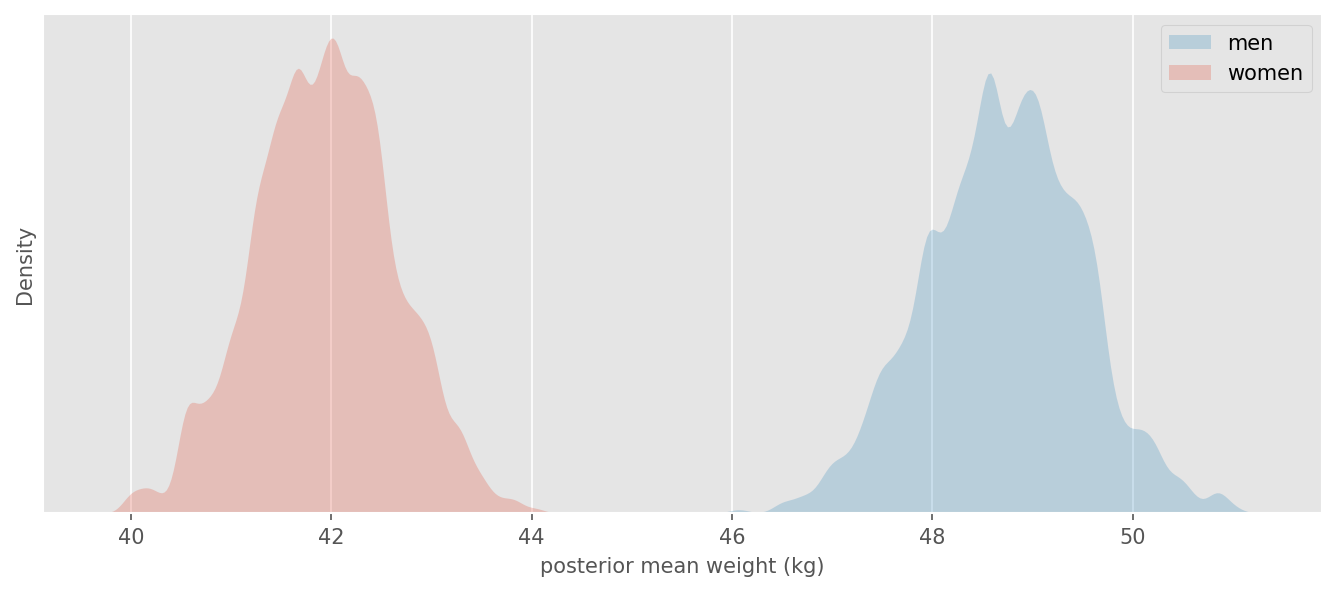

In [5]:
post_SW = m_SW.sample_posterior(seed, p_SW, (1000,))

ax = plt.subplot()
with attach(post_SW):
    dens(a[:, 1], color="C1", label="men")
    dens(a[:, 0], color="C0", label="women")
    ax.set(xlabel="posterior mean weight (kg)", yticks=[])
    ax.legend();

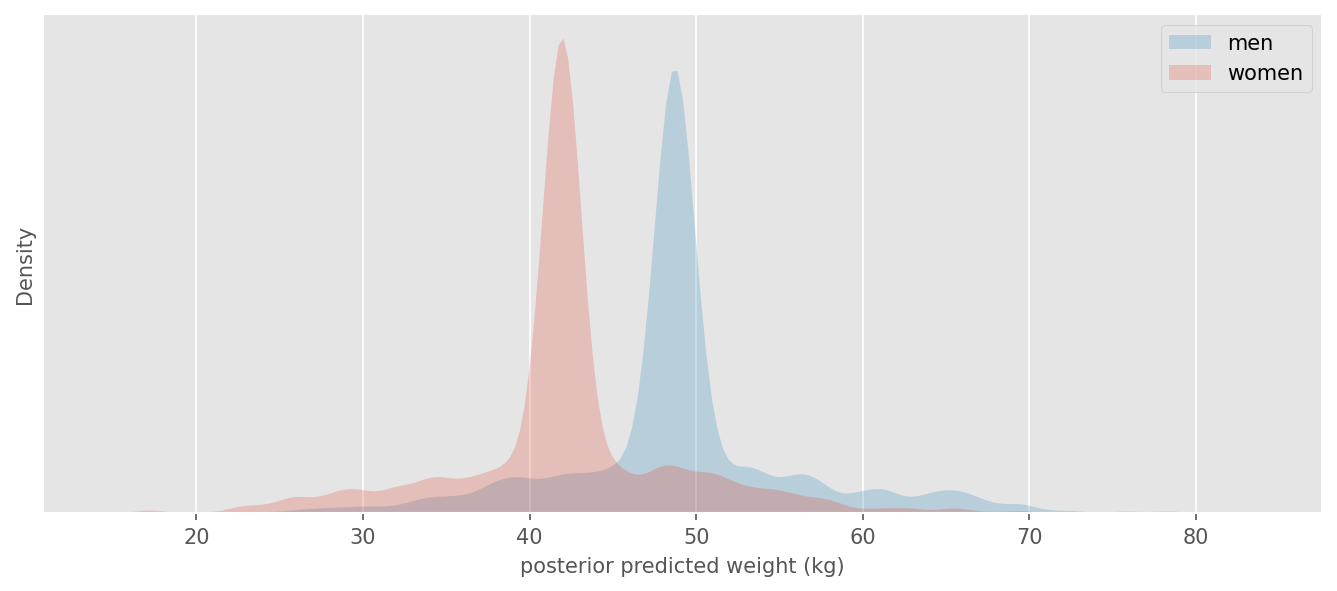

In [6]:
ax = plt.subplot()
with attach(post_SW):
    W0 = rnorm(1000, a[:, 0], sigma)
    W1 = rnorm(1000, a[:, 1], sigma)
    dens(W1, color="C1", label="men")
    dens(W0, color="C0", label="women")
    ax.set(xlabel="posterior predicted weight (kg)", yticks=[])
    ax.legend();

### Always be contrasting

It's never legitimate to draw conclusions from the overlap of parameters' posterior. 

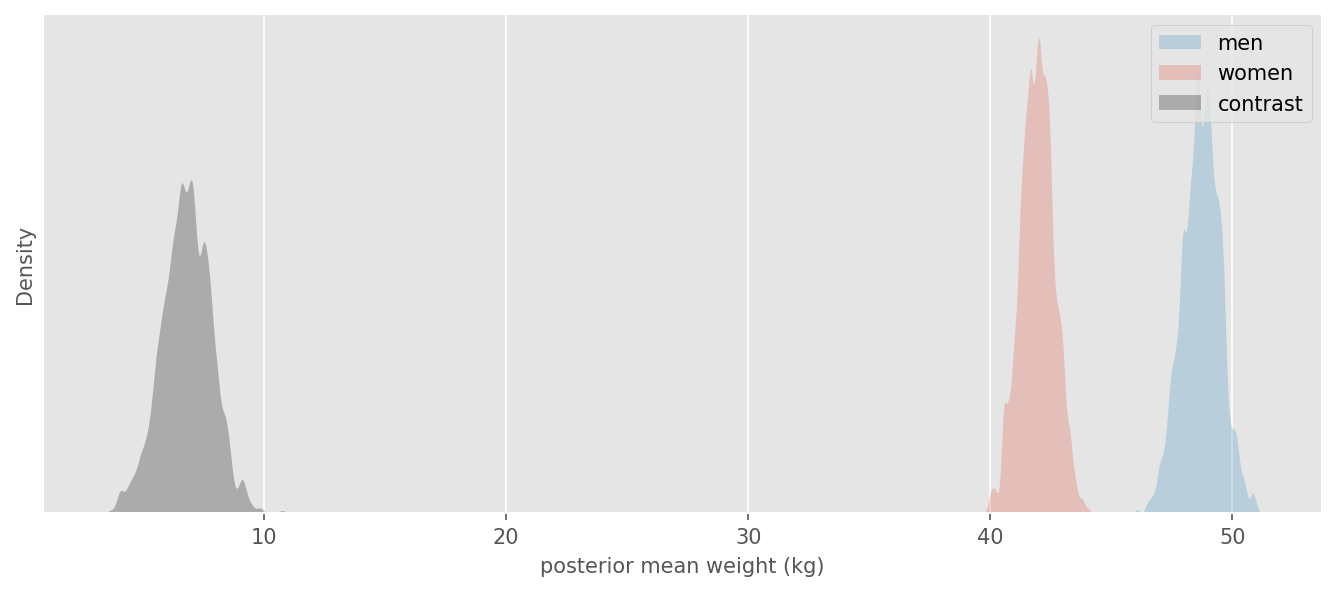

In [7]:
ax = plt.subplot()
post_SW["a_diff"] = post_SW["a"][:, 1] - post_SW["a"][:, 0]

with attach(post_SW):
    dens(a[:, 1], color="C1", label="men")
    dens(a[:, 0], color="C0", label="women")
    dens(a_diff, color="k", label="contrast")
    ax.set(xlabel="posterior mean weight (kg)", yticks=[])
    ax.legend();

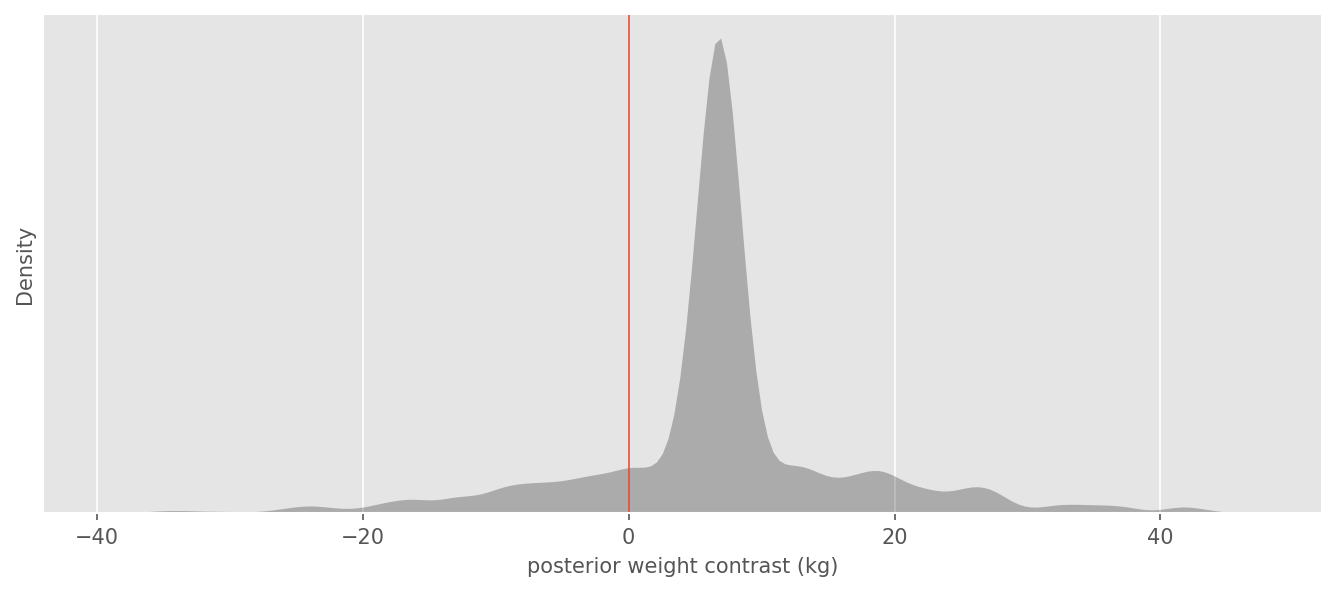

In [8]:
ax = plt.subplot()
W_contrast = W1 - W0
dens(W_contrast, color="k")
ax.axvline(0)
ax.set(xlabel="posterior weight contrast (kg)", yticks=[]);

### Q: what's the direct effect of S on W?
Contrast at each height.

In [9]:
def f_SHW(S, H, Hbar, W=None):
    n_sexes = len(set(S))
    a = sample("a", dist.Normal(60, 10).expand([n_sexes]))
    b = sample("b", dist.Uniform(0, 1).expand([n_sexes]))
    sigma = sample("sigma", dist.Uniform(0, 10))
    mu = deterministic("mu", a[S] + b[S]*(H - Hbar))
    sample("W", dist.Normal(mu, sigma), obs=W)
    
    
dat = dict(W=d.weight.values,
           H=d.height.values,
           Hbar=d.height.mean(),
           S=d.male.values)
m_SHW = AutoLaplaceApproximation(f_SHW)
p_SHW = (SVI(f_SHW, m_SHW, Adam(.3), Trace_ELBO())
            .run(seed, 3000, **dat).params)

100%|████████████████████| 3000/3000 [00:01<00:00, 2148.68it/s, init loss: 17241.7109, avg. loss [2851-3000]: 1019.9441]


In [10]:
post_SHW = m_SHW.sample_posterior(seed, p_SHW, (1, 1000))
precis(post_SHW, pars=["a", "b", "sigma"])

,mean,sd,5.5%,94.5%
a[0],45.15,0.43,44.46,45.84
a[1],45.07,0.45,44.39,45.80
b[0],0.65,0.06,0.56,0.74
b[1],0.61,0.06,0.52,0.70
sigma,4.24,0.16,3.98,4.50


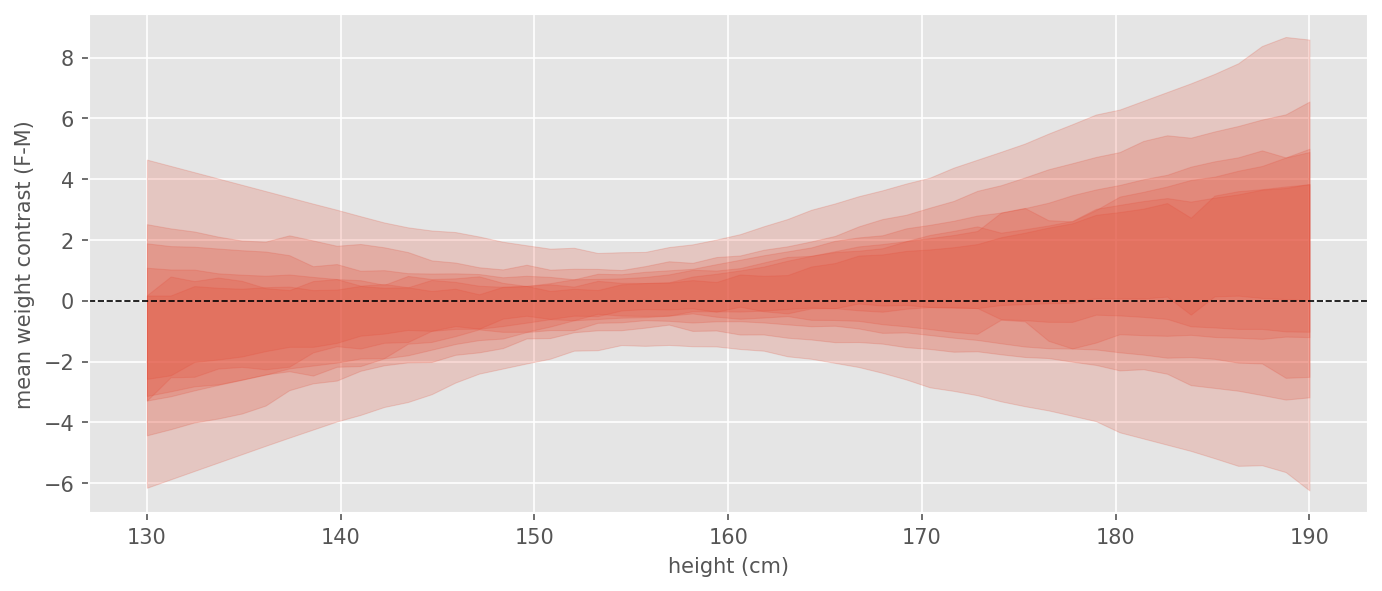

In [11]:
ax = plt.subplot()
H_seq = jnp.linspace(130, 190, 50)

muF = Predictive(f_SHW, post_SHW, return_sites=["mu"], batch_ndims=2) \
                (seed, S=np.repeat(0, 50), H=H_seq, Hbar=d.height.mean())["mu"]
muF = muF.squeeze(0)
muM = Predictive(f_SHW, post_SHW, return_sites=["mu"], batch_ndims=2) \
                (seed, S=np.repeat(1, 50), H=H_seq, Hbar=d.height.mean())["mu"]
muM = muM.squeeze(0)
mu_contrast = muF - muM

for p in [.5, .6, .7, .8, .9, .99]:
    shade(H_seq, hpdi(mu_contrast, p), alpha=.2)
ax.axhline(0, linestyle="--", c="k")
ax.set(xlabel="height (cm)", 
       ylabel="mean weight contrast (F-M)");

Roughly at each height, according to the model and the data, there is no difference in mean weight between men and women, meaning there is no direct effect of sex on weight. 

Notice that for the most tallest individuals, women are heavier than men at each of these extremely large heights, and opposite thing happens on the extremely short side. This is due to the slopes' difference.

### Full Luxury Bayes

We used two Bayesian models for two estimands. But we can equivalently just use one model for the entire causal system. Then use the joint posterior to compute each estimand.

In [12]:
def f_SHW_full(S, Hbar, H=None, W=None):
    n_sexes = 2
    a = sample("a", dist.Normal(60, 10).expand([n_sexes]))
    b = sample("b", dist.Uniform(0, 1).expand([n_sexes]))
    sigma = sample("sigma", dist.Uniform(0, 10))
    
    h = sample("h", dist.Normal(160, 10).expand([n_sexes]))
    tau = sample("tau", dist.Uniform(0, 10))
    H = sample("H", dist.Normal(h[S], tau), obs=H)
    
    mu = deterministic("mu", a[S] + b[S]*(H - Hbar))
    sample("W", dist.Normal(mu, sigma), obs=W)
    

dat = dict(S=d.male.values,
           H=d.height.values,
           Hbar=d.height.mean(),
           W=d.weight.values)
m_SHW_full = AutoLaplaceApproximation(f_SHW_full)
p_SHW_full = (SVI(f_SHW_full, m_SHW_full, Adam(1), Trace_ELBO())
                 .run(seed, 2000, **dat).params)


100%|████████████████████| 2000/2000 [00:01<00:00, 1517.17it/s, init loss: 75031.9062, avg. loss [1901-2000]: 2191.9246]


In [13]:
post_SHW_full = m_SHW_full.sample_posterior(seed, p_SHW_full, (1, 1000))
precis(post_SHW_full, pars=["a", "h", "b", "sigma", "tau"])

,mean,sd,5.5%,94.5%
a[0],45.17,0.43,44.49,45.84
a[1],45.11,0.46,44.40,45.84
h[0],149.52,0.43,148.84,150.24
h[1],160.36,0.48,159.66,161.21
b[0],0.65,0.06,0.56,0.74
b[1],0.61,0.05,0.53,0.70
sigma,4.23,0.17,3.95,4.47
tau,6.17,0.28,5.66,6.54


Causal effect is the consequence of intervention. So now simulate each intervention.

1. Total causal effect of S on W: consequence of changing S -> "$p(W|do(S))$"

In [38]:
n = int(1e4)
post_SHW_full = m_SHW_full.sample_posterior(seed, p_SHW_full, (n,))
Hbar = dat["Hbar"]

# simulate W for S=0
post_pred = Predictive(f_SHW_full, post_SHW_full, return_sites=["W", "mu"]) \
                      (seed, S=jnp.array([0, 1]), Hbar=d.height.mean())

with attach(post_pred):
    W_S1, W_S0 = W[:, 1], W[:, 0]
    mu_S1, mu_S0 = mu[:, 1], mu[:, 0]

# compute contrast
W_do_S = W_S1 - W_S0
mu_do_S = mu_S1 - mu_S0

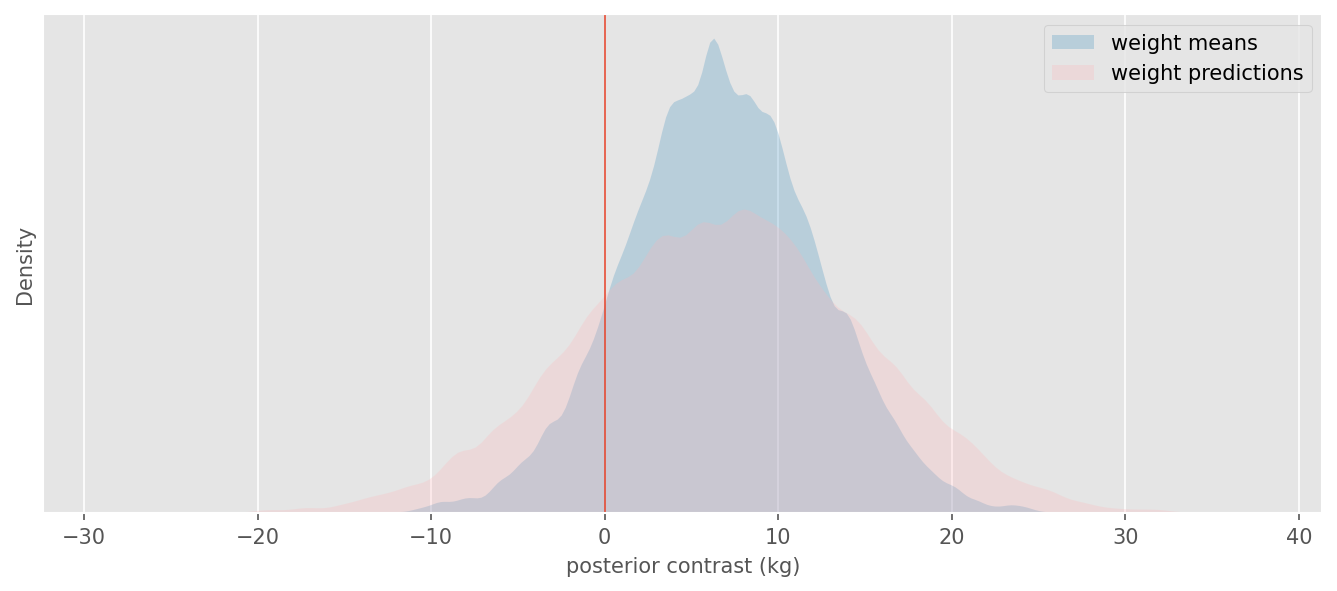

In [54]:
ax = plt.subplot();
dens(mu_do_S, color="C1", label="weight means")
dens(W_do_S, color="C6", label="weight predictions")
ax.axvline(0)
ax.set(xlabel="posterior contrast (kg)", yticks=[])
ax.legend();

2. Direct causal effect of S on W:

In [88]:
n = 50
H_seq = jnp.linspace(130, 190, n)

# simulate for S=0
post_pred = Predictive(f_SHW_full, post_SHW_full, return_sites=["W", "mu"]) \
                      (seed, S=0, Hbar=d.height.mean(), H=H_seq)

with attach(post_pred):
    muF, WF = mu, W
    
# simulate for S=1
post_pred = Predictive(f_SHW_full, post_SHW_full, return_sites=["W", "mu"]) \
                      (seed, S=1, Hbar=d.height.mean(), H=H_seq)

with attach(post_pred):
    muM, WM = mu, W

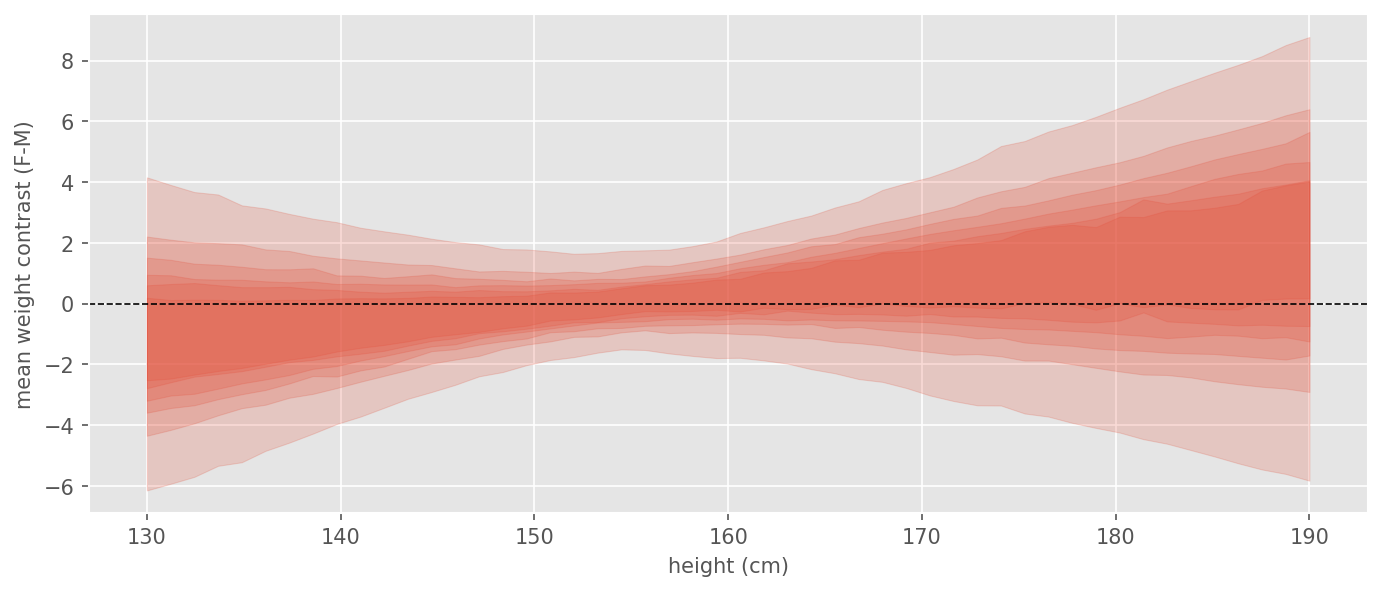

In [89]:
ax = plt.subplot()
mu_contrast = muF - muM
H_seq = jnp.linspace(130, 190, n)
for p in [.5, .6, .7, .8, .9, .99]:
    shade(H_seq, hpdi(mu_contrast, p), alpha=.2)
ax.axhline(0, linestyle="--", c="k")
ax.set(xlabel="height (cm)", 
       ylabel="mean weight contrast (F-M)");

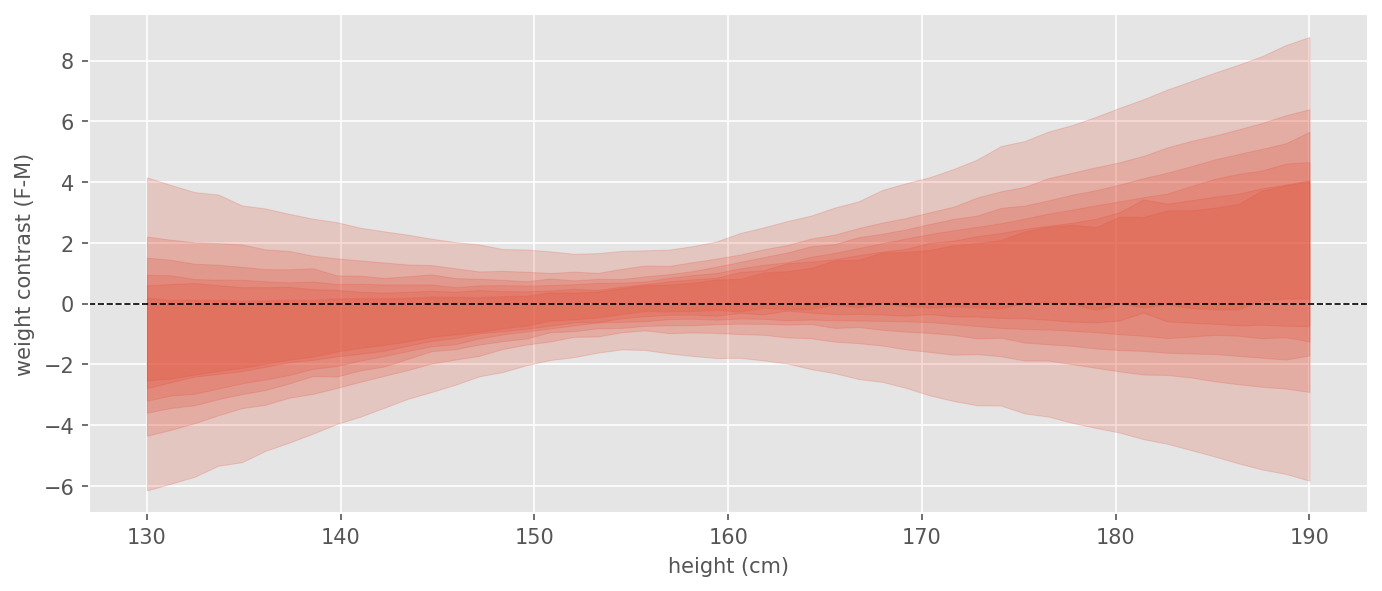

In [90]:
ax = plt.subplot()
W_contrast = WF - WM
H_seq = jnp.linspace(130, 190, n)
for p in [.5, .6, .7, .8, .9, .99]:
    shade(H_seq, hpdi(mu_contrast, p), alpha=.2)
ax.axhline(0, linestyle="--", c="k")
ax.set(xlabel="height (cm)", 
       ylabel="weight contrast (F-M)");